In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm
import copy
import pickle
from sklearn.metrics import classification_report
import time

# Trích xuất đặc trưng MFCC của 1 file

In [2]:
audio_file = "../input/simplespeech/14/19021240_NguyenTrongDat/2.wav"

In [3]:
ipd.Audio(audio_file,autoplay=True)

In [4]:
# load audio files with librosa
signal, sr = librosa.load(audio_file)

In [5]:
print(sr)

22050


In [6]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

In [7]:
mfccs.shape

(13, 270)

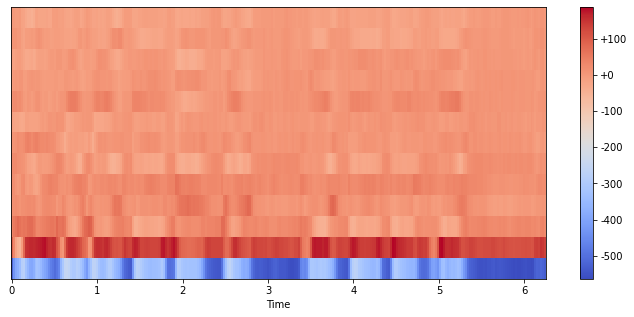

In [8]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [9]:
delta_mfccs = librosa.feature.delta(mfccs)

In [10]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [11]:
delta_mfccs.shape

(13, 270)

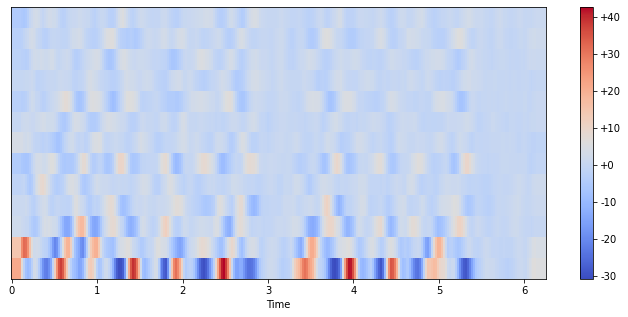

In [12]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

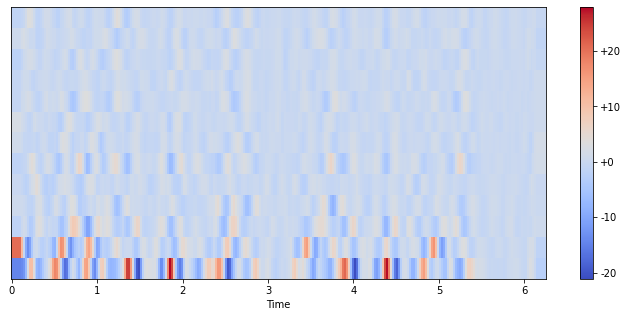

In [13]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [14]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [15]:
mfccs_features.shape

(39, 270)

In [16]:
class_names = ['xuong', 'len', 'phai', 'trai', 'nhay', 'ban', 'a', 'b', 'sil']

In [17]:
for i in class_names:
    !mkdir $i

In [18]:
!ls

__notebook__.ipynb  a  b  ban  len  nhay  phai	sil  trai  xuong


### Trích xuất đặc trưng MFCC

In [19]:

n_mfcc = 13
def extract_mfcc_features(file_path,n_mfcc):
    #load file âm thanh
    sound, sr = librosa.load(file_path)

    #trích xuất đặc trưng
    
    hop_length = 256



    win_length = 512
    # mfcc is 13 x T matrix
    mfcc = librosa.feature.mfcc(
        y=sound, sr=sr, n_mfcc=n_mfcc, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    
#     min_features = np.min(mfcc, axis=0)
#     max_features = np.max(mfcc, axis=0)
#     mfcc = (mfcc - min_features) / (max_features - min_features)
    
    
    mfcc = np.subtract(mfcc,np.mean(mfcc))
    delta_mfcc = librosa.feature.delta(mfcc,width=9)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    #chuẩn hoá
    mfcc_features = np.concatenate((mfcc, delta_mfcc, delta2_mfcc)).T
    
    
    return mfcc_features

# Tiền xử lý dữ liệu
Dữ liệu đang ở dạng 1 file wav chứa rất nhiều từ, chúng ta cần tách file wav thành nhiều file nhỏ và mỗi file chỉ có 1 từ duy nhất 
Hàm này sẽ tách toàn bộ âm thanh chứa trong data, chia nó về các folder data train với tên folder là các nhãn, trong các folder này chứa nhiều file wav, mỗi file wav chỉ chứa duy nhất tiếng của nhãn cần train

### Hàm cắt file wav

In [20]:
input_path = '../input/simplespeech/14/'
output_path = './'
from pydub import AudioSegment
def split_wav(t1,t2,name,dir_name,name_export):
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    name = input_path + dir_name +'/'+ name
    newAudio = AudioSegment.from_wav(name)
    newAudio = newAudio[t1:t2]
    name_export = output_path + name_export +".wav"
    newAudio.export(name_export, format="wav")

### Cắt thành nhiều file nhỏ

In [21]:
count = {}
for cname in class_names:
    count[cname] = 0
import os
import pandas as pd
for name_dir in os.listdir(os.path.join(input_path)):
    for i in os.listdir(os.path.join(input_path, name_dir)):
        if i.endswith('.wav'):
            path = i[:-3]
            path_txt = path + 'txt'
            if(os.path.exists(os.path.join(input_path,name_dir,path_txt))):
                df = pd.read_csv(os.path.join(input_path,name_dir,path_txt), sep="\t", header=None)
                for index, row in df.iterrows():
                    
                    isdir = os.path.isdir(path)
                    if(row[2]=='sli'):
                        row[2] = 'sil'
                    row[2]=row[2].replace(" ", "")
                    row[2]=row[2].lower()
                    if(row[2]=='pha'):
                        row[2] = 'phai'

                    if row[2]=='suong':
                        row[2] = 'xuong'
                    if row[2]=='xuon':
                        row[2] = 'xuong'
                    count[row[2]]+=1
                    name_export = row[2] +'/'+ row[2] + '_' + str(count[row[2]])
                    split_wav(row[0],row[1],i,name_dir,name_export)
                




In [22]:
print(count)

{'xuong': 476, 'len': 501, 'phai': 458, 'trai': 508, 'nhay': 546, 'ban': 474, 'a': 487, 'b': 540, 'sil': 594}


In [23]:
!ls 

__notebook__.ipynb  a  b  ban  len  nhay  phai	sil  trai  xuong


In [24]:
# import time
# for name_dir in os.listdir(os.path.join(output_path)):
#     if name_dir == 'sil' or name_dir =='__notebook_source__.ipynb':
#         continue
#     for i in os.listdir(os.path.join(output_path, name_dir)):
#         if i.endswith('.wav'):
#             ipd.display(ipd.Audio(os.path.join(output_path,name_dir,i),autoplay=True))
#             time.sleep(1)
    

# DTW Model

## Chuẩn bị dữ liệu
- Lấy ra một vài mẫu làm template
- Chọn ra các mẫu dữ liệu và tính toán đặc trưng


In [25]:
#Chọn dữ liệu, ở đây mỗi label em sử dụng 5 samples
n_samples = 4
features = {}
labels = {}
sr=22050
n_mfcc=13
for cname in class_names:
    file_paths = [os.path.join("",output_path, cname, ""+cname+"_"+str(i*50+1)+".wav") for i in range(n_samples)]
    for i in file_paths:
        ipd.display(ipd.Audio(i,autoplay=True))
        time.sleep(1)
    
    data = [extract_mfcc_features(file_path,n_mfcc) for file_path in file_paths]
    features[cname] = data
    labels[cname] = [cname for i in range(len(file_paths))]
for cname in class_names:
    print(cname,len(features[cname]))

xuong 4
len 4
phai 4
trai 4
nhay 4
ban 4
a 4
b 4
sil 4


In [26]:
data_arr = {}
for cname in class_names:
    data_arr[cname] = np.array(features[cname])
    for i in range(n_samples):
          data_arr[cname][i] = np.array(data_arr[cname][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
model = {}

# Với mỗi label tạo ra 1 template
for cname in class_names:
    print(cname)
    # Khởi tạo một số tham số
    n_iter = 60  # số vòng lặp
    dif_update = 1  # sự cải tiến của template so với vòng lặp trước 
    epsilon = 1e-5  # điều kiện dừng của sự cải tiến
    n_seg = 5  # số đoạn phân
    template = np.array([data_arr[cname][0].copy(), data_arr[cname][1].copy(),
                         data_arr[cname][2].copy(), data_arr[cname][3].copy()])

    # Mảng lưu các vạch ngăn cách các đoạn, khởi tạo các đoạn chia đều
    bound = np.array([np.zeros(n_seg + 1), np.zeros(n_seg + 1), np.zeros(n_seg + 1), np.zeros(n_seg + 1)])
    for i in range(n_samples):
        len_temp = template[i].shape[0]
        bound[i][0] = math.ceil(0)
        bound[i][n_seg] = math.ceil(len_temp)
        for j in range(n_seg - 1):
            bound[i][j + 1] = math.ceil((j + 1) * len_temp / n_seg)

    # Khởi tạo template (trung bình theo đoạn và giữa các samples)
    templateMean = np.array([np.zeros(39), np.zeros(39), np.zeros(39), np.zeros(39), np.zeros(39)])
    count = np.array([0, 0, 0, 0, 0])
    for j in range(n_seg):
        for i in range(n_samples):
            for k in range(int(bound[i][j]), int(bound[i][j + 1])):
                templateMean[j] += template[i][k]
                count[j] += 1
        templateMean[j] /= count[j]

    # Khởi tạo về bước nhảy trạng thái
    step_sizes_sigma = np.array([[1, 1], [1, 0], [1, 2]])

    # Vòng lặp cập nhật template
    while (n_iter > 0 and dif_update > epsilon):

        # Với mỗi sample
        for i in range(n_samples):

            # dtw trả về mảng quy hoạch động chi phí và đường đi tối ưu
            D, wp = librosa.sequence.dtw(template[i].T, templateMean.T, step_sizes_sigma=step_sizes_sigma)

            # cập nhật các đoạn theo sự dóng hàng mới nhất
            for j in range(n_seg - 1):
                for m in range(template[i].shape[0] - 1):
                    if (wp[m][1] == n_samples - j and wp[m + 1][1] == n_samples - j - 1):
                        bound[i][n_samples - j] = wp[m][0]

        # cập nhật template trung bình
        old_temp = copy.deepcopy(templateMean)
        templateMean = np.array([np.zeros(39), np.zeros(39), np.zeros(39), np.zeros(39), np.zeros(39)])
        count = np.array([0, 0, 0, 0, 0])
        for j in range(n_seg):
            for i in range(n_samples):
                for k in range(int(bound[i][j]), int(bound[i][j + 1])):
                    templateMean[j] += template[i][k]
                    count[j] += 1
            templateMean[j] /= count[j]
        n_iter -= 1

        # Tính toán sự cải thiện so với vòng lặp trước
        dif_update = np.sqrt(np.linalg.norm(templateMean - old_temp, ord="fro"))

    # Lưu lại template thu được cuối cùng
    model[cname] = templateMean


xuong


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


len
phai
trai
nhay
ban
a
b
sil


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [28]:
test_mfcc = []
test_labels = []

for cname in class_names:
    file_paths = [os.path.join("", output_path, cname, ""+cname+"_" +   str(i * 3 + 5) + ".wav") for i in
                  range(0,30)]
    data = [extract_mfcc_features(file_path, n_mfcc) for file_path in file_paths]
    for i in range(len(data)):
        test_mfcc.append(data[i])
        test_labels.append(cname)


In [29]:
y_pred = []

for i in range(0, len(test_mfcc)):
    cost = {}

    # Dóng hàng input với các template và chọn ra template có chi phí nhỏ nhất
    for cname in class_names:
        D, wp = librosa.sequence.dtw(test_mfcc[i].T, model[cname].T, step_sizes_sigma=step_sizes_sigma)
        cost[cname] = D[test_mfcc[i].T.shape[1] - 1][model[cname].T.shape[1] - 1]
    pred = min(cost, key=lambda k: cost[k])
    y_pred.append(pred)
#In kết quả quan sát
report = classification_report(test_labels, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       xuong       1.00      0.93      0.97        30
         len       0.84      0.87      0.85        30
        phai       0.91      1.00      0.95        30
        trai       0.83      0.83      0.83        30
        nhay       0.97      0.97      0.97        30
         ban       1.00      1.00      1.00        30
           a       1.00      1.00      1.00        30
           b       0.96      0.90      0.93        30
         sil       1.00      1.00      1.00        30

    accuracy                           0.94       270
   macro avg       0.95      0.94      0.94       270
weighted avg       0.95      0.94      0.94       270



In [30]:
!mkdir models_template_dtw
# save model
for cname in class_names:
    name = f'models_template_dtw/model_{cname}.pkl'
    with open(name, 'wb') as file: 
        pickle.dump(model[cname], file)
!zip -r models_template_dtw.zip models_template_dtw

  adding: models_template_dtw/ (stored 0%)
  adding: models_template_dtw/model_ban.pkl (deflated 13%)
  adding: models_template_dtw/model_a.pkl (deflated 11%)
  adding: models_template_dtw/model_b.pkl (deflated 9%)
  adding: models_template_dtw/model_trai.pkl (deflated 13%)
  adding: models_template_dtw/model_xuong.pkl (deflated 13%)
  adding: models_template_dtw/model_phai.pkl (deflated 10%)
  adding: models_template_dtw/model_nhay.pkl (deflated 10%)
  adding: models_template_dtw/model_len.pkl (deflated 9%)
  adding: models_template_dtw/model_sil.pkl (deflated 8%)


# HMM Model


In [31]:
# HMM state cho từng từ
states = [9, 9, 9, 9, 12, 9, 9, 9, 9]

In [32]:
a = extract_mfcc_features('../input/simplespeech/14/19020061_DuongNganHa/11-20.wav',13)
a.shape

(6310, 39)

In [33]:
#clean file
for cname in class_names:
    file_paths = [os.path.join(output_path, cname, i) for i in os.listdir(os.path.join(output_path, cname)) if i.endswith('.wav')]
    for file_path in file_paths:
        try:
            extract_mfcc_features(file_path,n_mfcc)
        except:
            print(file_path)
            !rm $file_path
all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join("./", cname, i) for i in os.listdir(os.path.join(output_path, cname)) if i.endswith('.wav')]
    data = [extract_mfcc_features(file_path,n_mfcc) for file_path in file_paths]
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]

./sil/sil_214.wav
./sil/sil_442.wav
./sil/sil_481.wav


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=0
  return f(*args, **kwargs)


./sil/sil_82.wav
./sil/sil_201.wav


In [34]:
from sklearn.model_selection import train_test_split

X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
for cname in class_names:
    x_train, x_test, _, y_test = train_test_split(
        all_data[cname], all_labels[cname], 
        test_size = 0.2, 
        random_state=42
    )
    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

In [35]:
for cname in class_names:
    print(cname,len(X['train'][cname]), len(X['test'][cname]), len(y['test'][cname]))

xuong 380 96 96
len 400 101 101
phai 366 92 92
trai 406 102 102
nhay 436 110 110
ban 379 95 95
a 389 98 98
b 432 108 108
sil 471 118 118


In [36]:
import hmmlearn.hmm as hmm

model = {}
for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0
    
    #trans matrix
    print(cname)
    print(trans_matrix) 

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx], 
        verbose=True, 
        n_iter=300, 
        startprob_prior=start_prob, 
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='mc',
        random_state=42
    )

    model[cname].fit(X=np.vstack(X['train'][cname]), lengths=[x.shape[0] for x in X['train'][cname]])

xuong
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2299221.5193             +nan
         2    -2206959.4736      +92262.0457
         3    -2192995.2478      +13964.2258
         4    -2186779.1674       +6216.0804
         5    -2181762.1585       +5017.0089
         6    -2178126.1509       +3636.0076
         7    -2175702.9950       +2423.1559
         8    -2174028.9950       +1674.0000
         9    -2172220.6825       +1808.3126
        10    -2171258.1614        +962.5211
        11    -2170817.8670        +440.2944
        12    -2170594.1476        +223.7194
        13    -2170482.7407        +111.4068
        14    -2170394.7683         +87.9724
        15    -2170318.6306         +76.1377
        16    -2170229.1806         +89.4500
        17    -2170144.2948         +84.8859
        18    -2170049.4255         +94.8693
        19    -2169866.5856        +182.8399
        20    -2169602.1724        +264.4132
        21    -2169424.3764        +177.7961
        22    -2169315.6129        +108.7634
        23

len
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2150517.6816             +nan
         2    -2030960.0058     +119557.6758
         3    -2003010.7144      +27949.2914
         4    -2001082.8172       +1927.8973
         5    -2000616.8990        +465.9182
         6    -2000285.5740        +331.3250
         7    -2000040.1738        +245.4002
         8    -1999875.3743        +164.7995
         9    -1999719.0695        +156.3048
        10    -1999531.8035        +187.2660
        11    -1999270.7323        +261.0711
        12    -1998959.2862        +311.4462
        13    -1998698.0088        +261.2774
        14    -1998445.4310        +252.5778
        15    -1998133.5781        +311.8529
        16    -1997760.1381        +373.4400
        17    -1997393.6278        +366.5104
        18    -1997072.8614        +320.7664
        19    -1996824.4376        +248.4238
        20    -1996685.4197        +139.0178
        21    -1996603.3004         +82.1193
        22    -1996518.0764         +85.2240
        23

phai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1940071.3308             +nan
         2    -1855305.7980      +84765.5328
         3    -1842827.9054      +12477.8926
         4    -1834890.3364       +7937.5690
         5    -1827403.1235       +7487.2129
         6    -1824286.4986       +3116.6249
         7    -1822880.2390       +1406.2596
         8    -1822285.3361        +594.9029
         9    -1822034.3020        +251.0341
        10    -1821816.1228        +218.1792
        11    -1821718.1479         +97.9749
        12    -1821673.8303         +44.3176
        13    -1821647.4041         +26.4262
        14    -1821625.5678         +21.8363
        15    -1821605.5602         +20.0076
        16    -1821587.6051         +17.9551
        17    -1821571.1675         +16.4377
        18    -1821553.4300         +17.7375
        19    -1821537.3432         +16.0868
        20    -1821522.8159         +14.5272
        21    -1821510.8460         +11.9700
        22    -1821501.0839          +9.7621
        23

trai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2243404.8694             +nan
         2    -2133639.8817     +109764.9877
         3    -2118066.6822      +15573.1995
         4    -2107839.4209      +10227.2613
         5    -2098321.1270       +9518.2939
         6    -2091099.8174       +7221.3096
         7    -2087172.9544       +3926.8630
         8    -2085577.2243       +1595.7301
         9    -2084770.5155        +806.7088
        10    -2084324.9258        +445.5897
        11    -2084038.9070        +286.0189
        12    -2083855.2968        +183.6101
        13    -2083731.5895        +123.7074
        14    -2083662.2746         +69.3149
        15    -2083618.4041         +43.8704
        16    -2083592.2092         +26.1949
        17    -2083572.8726         +19.3366
        18    -2083558.9543         +13.9183
        19    -2083549.0774          +9.8768
        20    -2083540.6107          +8.4667
        21    -2083533.2880          +7.3227
        22    -2083527.9900          +5.2979
        23

nhay
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2299825.5926             +nan
         2    -2184491.5541     +115334.0385
         3    -2162599.2221      +21892.3320
         4    -2154708.0746       +7891.1475
         5    -2150100.7871       +4607.2875
         6    -2147241.0799       +2859.7072
         7    -2143881.2365       +3359.8435
         8    -2139812.6096       +4068.6269
         9    -2137253.4994       +2559.1102
        10    -2135846.7307       +1406.7687
        11    -2135002.6607        +844.0700
        12    -2134497.2871        +505.3736
        13    -2134163.4547        +333.8324
        14    -2133933.3727        +230.0820
        15    -2133745.2287        +188.1440
        16    -2133584.0951        +161.1336
        17    -2133427.8318        +156.2633
        18    -2133268.0913        +159.7405
        19    -2133143.9551        +124.1362
        20    -2133027.2034        +116.7518
        21    -2132936.7693         +90.4340
        22    -2132859.1154         +77.6539
        23

ban
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1898196.2429             +nan
         2    -1789965.4062     +108230.8366
         3    -1774782.8094      +15182.5968
         4    -1772639.1700       +2143.6394
         5    -1771416.0584       +1223.1116
         6    -1770445.1852        +970.8732
         7    -1769664.0989        +781.0864
         8    -1769115.1929        +548.9060
         9    -1768613.0583        +502.1346
        10    -1768284.9196        +328.1387
        11    -1768101.8363        +183.0833
        12    -1767960.8830        +140.9533
        13    -1767844.4032        +116.4798
        14    -1767724.2587        +120.1444
        15    -1767591.4529        +132.8058
        16    -1767404.2320        +187.2209
        17    -1767131.3805        +272.8515
        18    -1766811.6945        +319.6860
        19    -1766498.5806        +313.1139
        20    -1766298.0621        +200.5185
        21    -1766218.8718         +79.1904
        22    -1766186.0424         +32.8294
        23

a
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1967571.1369             +nan
         2    -1827591.1310     +139980.0059
         3    -1792464.2663      +35126.8646
         4    -1786516.6685       +5947.5978
         5    -1783991.2308       +2525.4377
         6    -1782734.2751       +1256.9557
         7    -1781968.4892        +765.7859
         8    -1781333.0820        +635.4071
         9    -1780986.3673        +346.7147
        10    -1780794.1101        +192.2572
        11    -1780658.5676        +135.5425
        12    -1780588.5186         +70.0490
        13    -1780529.7025         +58.8161
        14    -1780490.4861         +39.2164
        15    -1780469.0172         +21.4690
        16    -1780447.6663         +21.3508
        17    -1780392.1008         +55.5655
        18    -1780244.4512        +147.6495
        19    -1780034.5555        +209.8957
        20    -1779995.9337         +38.6219
        21    -1779976.3050         +19.6287
        22    -1779962.8772         +13.4278
        23

b
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2318375.8875             +nan
         2    -2158545.0089     +159830.8786
         3    -2120408.6538      +38136.3551
         4    -2098312.3426      +22096.3112
         5    -2090617.9746       +7694.3680
         6    -2086946.7228       +3671.2518
         7    -2084843.7056       +2103.0172
         8    -2083631.8702       +1211.8354
         9    -2082743.2666        +888.6036
        10    -2082142.4538        +600.8129
        11    -2081794.7606        +347.6932
        12    -2081579.9108        +214.8497
        13    -2081409.3663        +170.5445
        14    -2081272.0272        +137.3392
        15    -2081188.4942         +83.5330
        16    -2081105.6239         +82.8703
        17    -2081038.9861         +66.6378
        18    -2080973.7678         +65.2183
        19    -2080929.2171         +44.5508
        20    -2080897.6856         +31.5314
        21    -2080862.5151         +35.1705
        22    -2080830.7167         +31.7984
        23

sil
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -2286545.1983             +nan
         2    -2139320.1354     +147225.0628
         3    -2107512.5720      +31807.5634
         4    -2097906.5975       +9605.9745
         5    -2092938.5445       +4968.0530
         6    -2091135.4728       +1803.0717
         7    -2090353.2684        +782.2044
         8    -2089941.9924        +411.2760
         9    -2089708.1376        +233.8548
        10    -2089543.4098        +164.7279
        11    -2089398.5551        +144.8547
        12    -2089266.8636        +131.6915
        13    -2089157.9278        +108.9358
        14    -2089041.3897        +116.5381
        15    -2088904.1483        +137.2414
        16    -2088738.5227        +165.6256
        17    -2088621.5966        +116.9261
        18    -2088535.2944         +86.3022
        19    -2088466.2563         +69.0381
        20    -2088423.2188         +43.0375
        21    -2088393.0849         +30.1340
        22    -2088374.4169         +18.6680
        23

In [37]:

!mkdir models_hmm
# save model
for cname in class_names:
    name = f'models_hmm/model_{cname}.pkl'
    with open(name, 'wb') as file: 
        pickle.dump(model[cname], file)

In [38]:
y_true = []
y_pred = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    print((np.array(y_true) == np.array(y_pred)).sum()/len(y_true))
print(y_true)
print(y_pred)


1.0
0.9898477157360406
0.9792387543252595
0.9744245524296675
0.9760479041916168
0.9765100671140939
0.9769452449567724
0.9763092269326683
0.9771739130434782
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [39]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       xuong       1.00      1.00      1.00        96
         len       1.00      0.98      0.99       101
        phai       0.92      0.96      0.94        92
        trai       0.96      0.96      0.96       102
        nhay       0.96      0.98      0.97       110
         ban       0.99      0.98      0.98        95
           a       0.97      0.98      0.97        98
           b       0.99      0.97      0.98       108
         sil       1.00      0.98      0.99       118

    accuracy                           0.98       920
   macro avg       0.98      0.98      0.98       920
weighted avg       0.98      0.98      0.98       920



In [40]:
#loadmodels
import pickle

model_train = {}
for key in class_names:
    name = f"models_hmm/model_{key}.pkl"
    with open(name, 'rb') as file:
        model_train[key] = pickle.load(file)

In [41]:
print(model_train)

{'xuong': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]]),
            verbose=True), 'len': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.

In [42]:
!zip -r models_hmm.zip models_hmm

  adding: models_hmm/ (stored 0%)
  adding: models_hmm/model_ban.pkl (deflated 23%)
  adding: models_hmm/model_a.pkl (deflated 20%)
  adding: models_hmm/model_b.pkl (deflated 20%)
  adding: models_hmm/model_trai.pkl (deflated 21%)
  adding: models_hmm/model_xuong.pkl (deflated 29%)
  adding: models_hmm/model_phai.pkl (deflated 22%)
  adding: models_hmm/model_nhay.pkl (deflated 24%)
  adding: models_hmm/model_len.pkl (deflated 24%)
  adding: models_hmm/model_sil.pkl (deflated 18%)
